In [1]:
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import os
import logging
import torch.cuda.amp as amp
import matplotlib.pyplot as plt

In [2]:
# Load an image and convert it to a tensor
def load_image(image_path):
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, emb_size, num_patches):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.emb_size = emb_size
        self.num_patches = num_patches

        # Linear projection of flattened patches
        self.patch_to_emb = nn.Linear(3 * patch_size * patch_size, emb_size)

        # Learnable positional encodings
        self.pos_embeddings = nn.Parameter(torch.randn(1, num_patches, emb_size))

    def forward(self, x):
        """
        Args:
        x (Tensor): Input tensor of shape (batch_size, channels, height, width)

        Returns:
        Tensor: Output tensor with embedded and position-encoded patches
        """
        # x shape: (batch_size, channels, height, width)
        # Create patches and flatten
        x = x.unfold(2, self.patch_size, self.patch_size)  # Create patches along height
        x = x.unfold(3, self.patch_size, self.patch_size)  # Create patches along width
        x = x.contiguous().view(
            x.size(0), -1, 3 * self.patch_size * self.patch_size
        )  # Flatten patches

        # Apply linear projection to each patch
        x = self.patch_to_emb(x)  # shape: (batch_size, num_patches, emb_size)

        # Add positional encodings
        x += self.pos_embeddings  # Broadcasting over the batch size

        return x


In [4]:
# Assuming an image path is specified
image_path = ("/home/linuxu/Documents/datasets/Tiny_LR/13.jpeg")
image_tensor = load_image(image_path)

In [5]:
# Initialize the PatchEmbedding module
patch_embedding = PatchEmbedding(patch_size=8, emb_size=256, num_patches=64)

# Move to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)
patch_embedding = patch_embedding.to(device)


In [6]:
# Apply the patch embedding module
embedded_patches = patch_embedding(image_tensor)

# Print out the shape of the output tensor
print("Shape of embedded patches:", embedded_patches.shape)


Shape of embedded patches: torch.Size([1, 64, 256])


In [7]:
# Initialize the model
embedding_dim = 256
num_patches = 64
# Visualize Positional Encodings
positional_encodings = patch_embedding.pos_embeddings.detach().cpu().numpy()


In [8]:
positional_encodings.shape

(1, 64, 256)

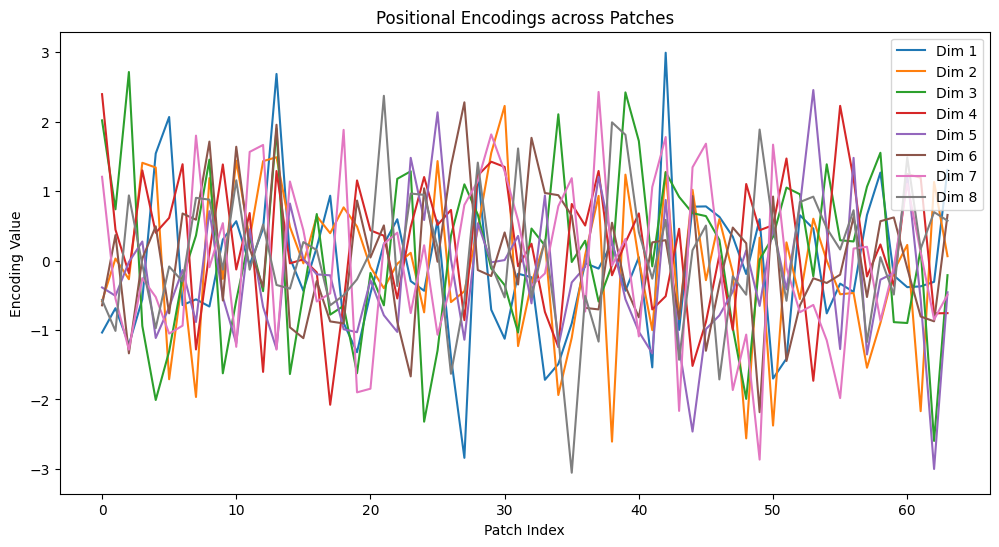

In [9]:

# Select a few dimensions to visualize
plt.figure(figsize=(12, 6))
for i in range(min(8, embedding_dim)):  # Visualize the first 8 dimensions
    plt.plot(positional_encodings[0, :, i], label=f'Dim {i+1}')
plt.title('Positional Encodings across Patches')
plt.xlabel('Patch Index')
plt.ylabel('Encoding Value')
plt.legend()
plt.show()

In [10]:
import math

class SineCosinePositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, num_patches, patch_size):
        super(SineCosinePositionalEncoding, self).__init__()
        self.patch_size = patch_size
        self.emb_size = embedding_dim
        self.num_patches = num_patches

        # Linear projection of flattened patches
        self.patch_to_emb = nn.Linear(3 * patch_size * patch_size, self.emb_size)

        
        # Create a positional encoding matrix of shape (num_patches, embedding_dim)
        position = torch.arange(num_patches).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * -(math.log(10000.0) / embedding_dim))
        pe = torch.zeros(num_patches, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('positional_encodings', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        # Create patches and flatten
        x = x.unfold(2, self.patch_size, self.patch_size)  # Create patches along height
        x = x.unfold(3, self.patch_size, self.patch_size)  # Create patches along width
        x = x.contiguous().view(
            x.size(0), -1, 3 * self.patch_size * self.patch_size
        )  # Flatten patches

        # Apply linear projection to each patch
        x = self.patch_to_emb(x)  # shape: (batch_size, num_patches, emb_size)

        # x has shape (batch_size, num_patches, embedding_dim)
        x += self.positional_encodings[:, :x.size(1), :]
        return x

In [11]:
# Initialize the model
embedding_dim = 256
num_patches = 64
model = SineCosinePositionalEncoding(embedding_dim, num_patches, patch_size=8).to(device)

# Forward pass
output = model(image_tensor)
print(output.shape)  # Check the output shape

torch.Size([1, 64, 256])


In [12]:
# Visualize Positional Encodings
positional_encodings = model.positional_encodings.detach().cpu().numpy()

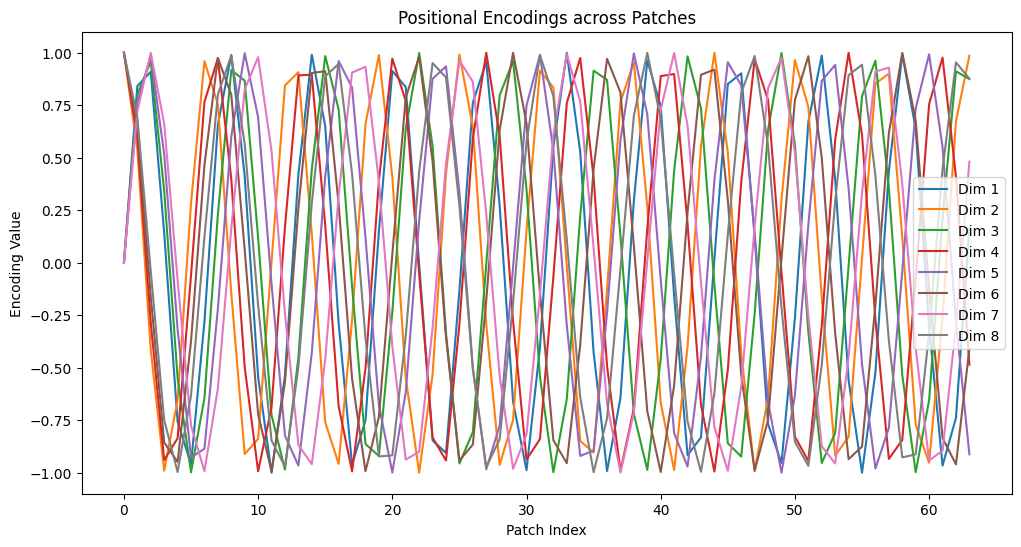

In [13]:

# Select a few dimensions to visualize
plt.figure(figsize=(12, 6))
for i in range(min(8, embedding_dim)):  # Visualize the first 8 dimensions
    plt.plot(positional_encodings[0, :, i], label=f'Dim {i+1}')
plt.title('Positional Encodings across Patches')
plt.xlabel('Patch Index')
plt.ylabel('Encoding Value')
plt.legend()
plt.show()

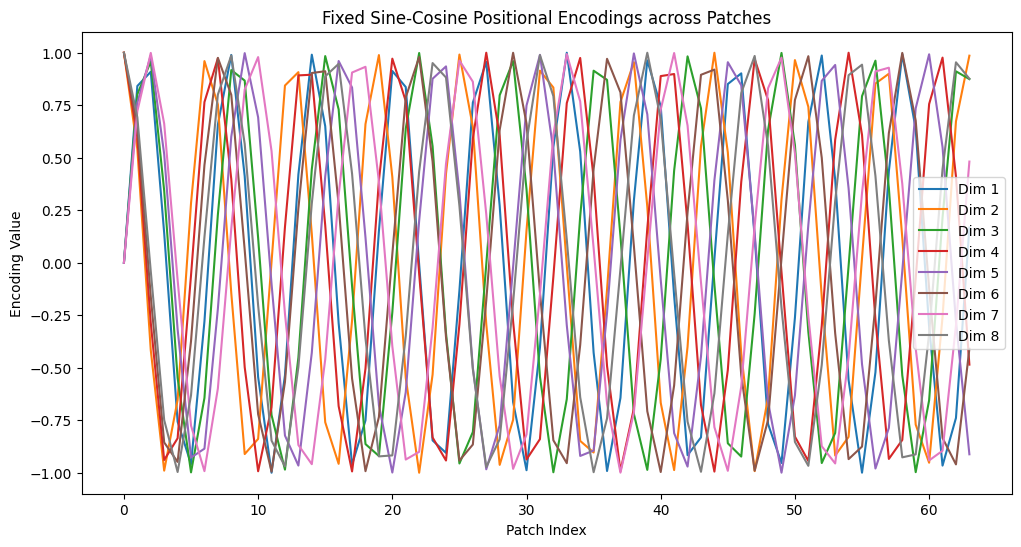

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class SineCosinePositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, num_patches):
        super(SineCosinePositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.positional_encoding = self.create_positional_encoding()
    
    def create_positional_encoding(self):
        # Create the sine-cosine positional encodings
        position = np.arange(self.num_patches)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.embedding_dim, 2) * -(np.log(10000.0) / self.embedding_dim))
        pos_enc = np.zeros((self.num_patches, self.embedding_dim))
        pos_enc[:, 0::2] = np.sin(position * div_term)
        pos_enc[:, 1::2] = np.cos(position * div_term)
        return torch.from_numpy(pos_enc).float().unsqueeze(0)  # Add batch dimension
    
    def forward(self, x):
        # x shape: (batch_size, num_patches, embedding_dim)
        return x + self.positional_encoding.to(x.device)

class VisionTransformerModel(nn.Module):
    def __init__(self, patch_size, embedding_dim, num_patches):
        super(VisionTransformerModel, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.projection = nn.Linear(patch_size * patch_size * 3, embedding_dim)
        self.positional_encoding = SineCosinePositionalEncoding(embedding_dim, num_patches)
    
    def forward(self, x):
        # Flatten and project patches
        x = x.view(x.size(0), x.size(1), -1)  # (batch_size, num_patches, patch_size * patch_size * 3)
        x = self.projection(x)  # Linear projection (embedding)
        
        # Add positional encodings
        x = self.positional_encoding(x)
        
        return x

# Example usage:
batch_size = 1
channels = 3
image_size = 64  # Assume a 64x64 image
patch_size = 8   # 8x8 patches
embedding_dim = 256
num_patches = (image_size // patch_size) ** 2  # 64 patches

# Simulate a batch of patches from an image
dummy_patches = torch.randn(batch_size, num_patches, patch_size * patch_size * channels).cuda()

# Initialize the model
model = VisionTransformerModel(patch_size, embedding_dim, num_patches).cuda()

# Pass through the model
embedded_patches_with_positional_encoding = model(dummy_patches)

# Visualize the positional encodings added to the patches
positional_encodings = model.positional_encoding.positional_encoding.detach().cpu().numpy()

# Visualize a few dimensions of the positional encoding
plt.figure(figsize=(12, 6))
for i in range(min(8, embedding_dim)):  # Visualize the first 8 dimensions
    plt.plot(positional_encodings[0, :, i], label=f'Dim {i+1}')
plt.title('Fixed Sine-Cosine Positional Encodings across Patches')
plt.xlabel('Patch Index')
plt.ylabel('Encoding Value')
plt.legend()
plt.show()


In [15]:
import torch
import torch.nn as nn
from embedding import ImageEmbedding

# Example RGB image (batch_size=1, channels=3, height=64, width=64)
rgb_image = torch.randn(1, 3, 64, 64).cuda()

# Parameters
patch_size = 8
embedding_dim = 256
num_patches = 64

# Flatten the image into patches
patches = rgb_image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
patches = patches.contiguous().view(1, 3, -1, patch_size, patch_size)  # (1, 3, 64, 8, 8)
patches = patches.permute(0, 2, 1, 3, 4)  # (1, 64, 3, 8, 8)
patches = patches.contiguous().view(1, num_patches, -1)  # (1, 64, 192)

# Initialize the model
model = ImageEmbedding(patch_size, embedding_dim, num_patches).cuda()

# Pass through the model to get embedded patches with positional encoding
embedded_patches_with_positional_encoding = model(patches)

# Check the shape of the output
print(embedded_patches_with_positional_encoding.shape)  # Should be (1, 64, 256)


torch.Size([1, 64, 256])


In [16]:
import torch

def embed_image(image, model, patch_size=8, embedding_dim=256):
    """
    Embed an RGB image into patches, apply linear projection, and add positional encodings.

    Args:
        image (torch.Tensor): Input image tensor of shape (1, 3, H, W).
        model (nn.Module): Vision Transformer model with embedding and positional encoding layers.
        patch_size (int): The size of each patch (default: 8).
        embedding_dim (int): The dimension of the embedding space (default: 256).

    Returns:
        torch.Tensor: Embedded image patches with positional encodings, shape (1, num_patches, embedding_dim).
    """
    # Ensure the image is on the correct device
    device = next(model.parameters()).device
    image = image.to(device)

    # Unfold the image into patches
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(1, 3, -1, patch_size, patch_size)  # (1, 3, num_patches, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)  # (1, num_patches, 3, patch_size, patch_size)
    patches = patches.contiguous().view(1, patches.size(1), -1)  # (1, num_patches, 3 * patch_size * patch_size)

    # Pass the patches through the model (embedding + positional encoding)
    embedded_patches = model(patches)

    return embedded_patches

# Example usage:
# Assume we have a model instance of VisionTransformerModel

# Example RGB image (batch_size=1, channels=3, height=64, width=64)
rgb_image = torch.randn(1, 3, 64, 64).cuda()

# Initialize the model
model = ImageEmbedding(patch_size=8, embedding_dim=256, num_patches=64).cuda()

# Embed the image
embedded_image = embed_image(rgb_image, model, patch_size=8, embedding_dim=256)

# Check the shape of the output
print(embedded_image.shape)  # Should be (1, 64, 256)


torch.Size([1, 64, 256])


In [17]:
from embedding import embed_image_sin_cosine

res = embed_image_sin_cosine("/home/linuxu/Documents/datasets/Tiny_LR/13.jpeg", model, patch_size=8, device=device)

In [18]:
res.shape

torch.Size([1, 64, 256])

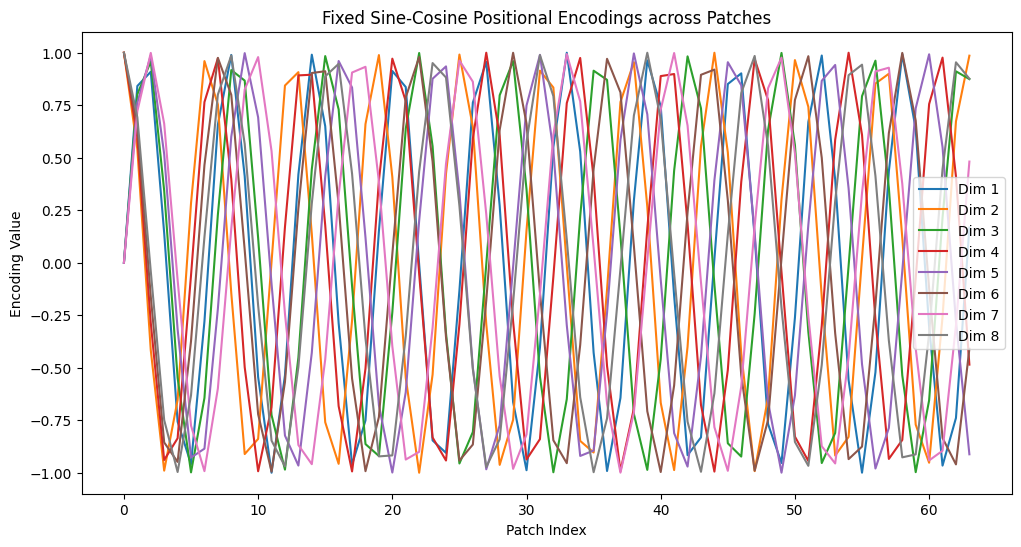

In [19]:

# Visualize the positional encodings added to the patches
positional_encodings = model.positional_encoding.positional_encoding.detach().cpu().numpy()

# Visualize a few dimensions of the positional encoding
plt.figure(figsize=(12, 6))
for i in range(min(8, embedding_dim)):  # Visualize the first 8 dimensions
    plt.plot(positional_encodings[0, :, i], label=f'Dim {i+1}')
plt.title('Fixed Sine-Cosine Positional Encodings across Patches')
plt.xlabel('Patch Index')
plt.ylabel('Encoding Value')
plt.legend()
plt.show()